# Exploring Materials Synthesis with MP Data and Reaction Networks

**Author:** Matthew McDermott  
**Last updated:** 08/05/21

![](assets/banner.png)

### Goal
*Learn how to build & interpret phase diagrams using MP data and apply these to predict reaction pathways in inorganic materials synthesis.*

### Outline

1. Identifying a target system
2. Building phase diagrams
3. Predicting interface reactions between solids
4. Enumerating all possible reactions to a specific target phase
5. Constructing a reaction network from enumerated reactions
6. Finding and balancing reaction pathways 

## 1. Identifying a target system

**Scenario:** 

While researching ferroelectric materials, you stumble upon a compound that has shown much promise as a multiferroic material: **yttrium manganese oxide, YMnO$_3$**. When you consult the literature, it looks like there are many different approaches for making this material: solid-state synthesis, chimie douce methods, microwave-assisted synthesis, pulsed laser deposition, hydrothermal synthesis, etc. 

In almost all of the papers you find, however, the authors describe significant difficulty in synthesizing phase-pure YMnO$_3$. For example:
- _"... observation that crystallization at low temperature or high oxygen partial pressures gives a mixture of Y2Mn2O7 together with YMnO3" Brinks et al., Journal of Solid State Chemistry 129, 334-340 (1997)._
- _"The solid state synthesis of YMnO3 requires very long procedure with repeated heating and grinding" Z. Brankovic et al. Ceramics International 41 (2015)_
- _"There are still challenges to be addressed with respect to hydrothermal synthesis of h-YMnO3, most notably the difficulty in synthesising phase pure h-YMnO3. This is a result of the complexity of the system, with a total of eight crystalline phases having been detected throughout the course of the reaction." Marshall et al., Chem Eur. J 2020, 26, 9330-9337 (2020)._


Being familiar with the Materials Project database and *pymatgen*, you decide to check the database to see if it can help answer the question: **why is phase-pure YMnO$_3$ so difficult to synthesize?**

We previously learned how to use the *MPRester* to access computed data on the Materials Project. Let's start by importing `MPRester`:

In [1]:
from mp_api.matproj import MPRester

### 1.1 EXERCISE: Acquiring entries from MP
Using the `MPRester`, acquire alll entries from the Materials Project with the composition YMnO$_3$ in the cell below:

In [2]:
with MPRester() as mpr:
    entries = mpr.get_entries(chemsys_formula="YMnO3")

/Users/mcdermott/miniconda3/envs/workshop/lib/python3.9/site-packages/maggma/api/utils.py:104: RuntimeWarning: fields may not start with an underscore, ignoring "_framework_formula"
  for model in get_flat_models_from_model(pydantic_model)
/Users/mcdermott/miniconda3/envs/workshop/lib/python3.9/site-packages/maggma/api/utils.py:104: RuntimeWarning: fields may not start with an underscore, ignoring "_stable_entries"
  for model in get_flat_models_from_model(pydantic_model)
/Users/mcdermott/miniconda3/envs/workshop/lib/python3.9/site-packages/maggma/api/utils.py:104: RuntimeWarning: fields may not start with an underscore, ignoring "_unstable_entries"
  for model in get_flat_models_from_model(pydantic_model)


### 1.2 Exploring downloaded entries

Great! Now let's take a look at one of the downloaded entry objects:

In [3]:
print(entries[0])

mp-19227 ComputedStructureEntry - Y2 Mn2 O6    (YMnO3)
Energy (Uncorrected)     = -83.6409  eV (-8.3641  eV/atom)
Correction               = -7.4580   eV (-0.7458  eV/atom)
Energy (Final)           = -91.0989  eV (-9.1099  eV/atom)
Energy Adjustments:
  MP2020 anion correction (oxide): -4.1220   eV (-0.4122  eV/atom)
  MP2020 GGA/GGA+U mixing correction (Mn): -3.3360   eV (-0.3336  eV/atom)
Parameters:
  potcar_spec            = [{'titel': 'PAW_PBE Y_sv 06Sep2000', 'hash': '4ed187e77cd54f198bb88020278b143d'}, {'titel': 'PAW_PBE Mn_pv 07Sep2000', 'hash': 'fa52f891f234d49bb4cb5ea96aae8f98'}, {'titel': 'PAW_PBE O 08Apr2002', 'hash': '7a25bc5b9a5393f46600a4939d357982'}]
  is_hubbard             = True
  hubbards               = {'Y': 0.0, 'Mn': 3.9, 'O': 0.0}
  run_type               = GGA+U
Data:
  oxide_type             = oxide
  aspherical             = True
  last_updated           = 2021-02-07 02:11:30.205000
  task_id                = mp-1871444
  oxidation_states       = {'Y': 3.0, 

In the `ComputedStructureEntry` printout, we can see the uncorrected energy, correction, final energy, and the various parameters/data associated with the calculation.

Since this is hard to interpret, it will be easier for us to reformat the entries into a *pandas* `DataFrame` with the relevant information. First we import *pandas*:

In [4]:
import pandas

And then we create a function to help us wrangle the entries into the `DataFrame` format:

In [5]:
def get_df_from_entries(entries):
    formulas = [e.composition.reduced_formula for e in entries]
    energies = [e.energy_per_atom for e in entries]
    spacegroups = [e.structure.get_space_group_info()[0] for e in entries]
    structures = [e.structure for e in entries]
    
    data = {"formula": formulas, "energy": energies, "spacegroup": spacegroups, "entry":entries}
    
    df = pandas.DataFrame(data).sort_values("energy")
    
    return df

The dataframe can now be created by calling the function:

In [6]:
df = get_df_from_entries(entries)
df

formula    energy spacegroup  \
4   YMnO3 -9.130481     P6_3cm   
0   YMnO3 -9.109891   P6_3/mmc   
3   YMnO3 -9.107394       Pnma   
1   YMnO3 -8.805429      Pm-3m   
2   YMnO3 -8.731478       Pnma   

                                               entry  
4  mp-19385 ComputedStructureEntry - Y6 Mn6 O18  ...  
0  mp-19227 ComputedStructureEntry - Y2 Mn2 O6   ...  
3  mp-20699 ComputedStructureEntry - Y4 Mn4 O12  ...  
1  mp-1434307 ComputedStructureEntry - Y1 Mn1 O3 ...  
2  mp-20699 ComputedStructureEntry - Y4 Mn4 O12  ...

 We see that there are several polymorphs of similar energy. The lowest energy polymorph is the hexagonal YMnO$_3$ phase which is well known as the stable phase in the literature:

In [7]:
structure = df.iloc[0]["entry"].structure
print(structure)

Full Formula (Y6 Mn6 O18)
Reduced Formula: YMnO3
abc   :   6.233022   6.233022  11.589090
angles:  90.000000  90.000000 119.999996
Sites (30)
  #  SP           a         b         c    magmom
---  ----  --------  --------  --------  --------
  0  Y     0.666667  0.333333  0.233045     0.019
  1  Y     0.333333  0.666667  0.733045     0.019
  2  Y     0.666667  0.333333  0.733045     0.019
  3  Y     0.333333  0.666667  0.233045     0.019
  4  Y     0         0         0.775978     0.016
  5  Y     0         0         0.275978     0.016
  6  Mn    0.666399  0         0.501375     3.939
  7  Mn    0.666399  0.666399  0.001375     3.931
  8  Mn    0         0.333601  0.001375     3.931
  9  Mn    0         0.666399  0.501375     3.939
 10  Mn    0.333601  0.333601  0.501375     3.939
 11  Mn    0.333601  0         0.001375     3.931
 12  O     0.666667  0.333333  0.021222    -0.035
 13  O     0.333333  0.666667  0.521222    -0.026
 14  O     0.666667  0.333333  0.521222    -0.026
 15  O  

If we want to interactively view this structure in JupyterLab, we can also import crystal_toolkit to view it:

In [8]:
import crystal_toolkit
structure

If you see this text, the Crystal Toolkit Jupyter Lab 

extension is not installed. You can install it by running 

"pip install crystaltoolkit-extension" 

from the same environment you run "jupyter lab". 

This only works in Jupyter Lab 3.x or above.


Structure Summary
Lattice
    abc : 6.2330216584852325 6.2330216584852325 11.58909
 angles : 90.0 90.0 119.99999637504301
 volume : 389.9215651386502
      A : 3.116511 -5.397955 0.0
      B : 3.116511 5.397955 0.0
      C : 0.0 0.0 11.58909
PeriodicSite: Y (3.1165, -1.7993, 2.7008) [0.6667, 0.3333, 0.2330]
PeriodicSite: Y (3.1165, 1.7993, 8.4953) [0.3333, 0.6667, 0.7330]
PeriodicSite: Y (3.1165, -1.7993, 8.4953) [0.6667, 0.3333, 0.7330]
PeriodicSite: Y (3.1165, 1.7993, 2.7008) [0.3333, 0.6667, 0.2330]
PeriodicSite: Y (0.0000, 0.0000, 8.9929) [0.0000, 0.0000, 0.7760]
PeriodicSite: Y (0.0000, 0.0000, 3.1983) [0.0000, 0.0000, 0.2760]
PeriodicSite: Mn (2.0768, -3.5972, 5.8105) [0.6664, 0.0000, 0.5014]
PeriodicSite: Mn (4.1537, 0.0000, 0.0

## 2. Building phase diagrams

Now that we've confirmed the existence of the target phase within the MP database, we'd like to better understand phase composition within the Y-Mn-O system. This means answering questions suchs as:

1. Just how stable is YMnO$_3$? 
2. How much energy is released upon formation of YMnO$_3$ from binary oxides vs. the elements?
3. What other phases might compete against the formation of YMnO$_3$? 
4. What kinds of oxygen chemical potentials stabilize YMnO$_3$? 

These are all questions that can be answered by constructing phase diagrams within *pymatgen*.

### 2.1 EXERCISE: Acquiring all entries within the chemical system
Let's start by downloading entries for the full Y-Mn-O system using `MPRester`. How many entries exist within the full Y-Mn-O system?

In [9]:
with MPRester() as mpr:
    entries = mpr.get_entries_in_chemsys("Y-Mn-O")

In [10]:
print(len(entries))

160


### 2.2 Compositional phase diagrams
Now that we have all the entrise within the Y-Mn-O system, we can create a ternary compositional phase diagram by simply passing the list of entries to create a `PhaseDiagram` object. Let's first import the phase_diagram module:

In [11]:
from pymatgen.analysis.phase_diagram import PhaseDiagram

pd = PhaseDiagram(entries)

And create the phase diagram:

In [12]:
pd = PhaseDiagram(entries)

To plot the phase diagram, we can either:
1. Create a `PDPlotter` object and call `get_plot()` with custom arguments
2. Create a `PDPlotter` object and call `show()`
3. In JupyterLab, just type the name of the phase diagram object in a cell and click Enter

Let's do option 1. First we import `PDPlotter`:

In [13]:
from pymatgen.analysis.phase_diagram import PDPlotter

And then we create the plotting object and call the `get_plot` function:

In [14]:
plotter = PDPlotter(pd)

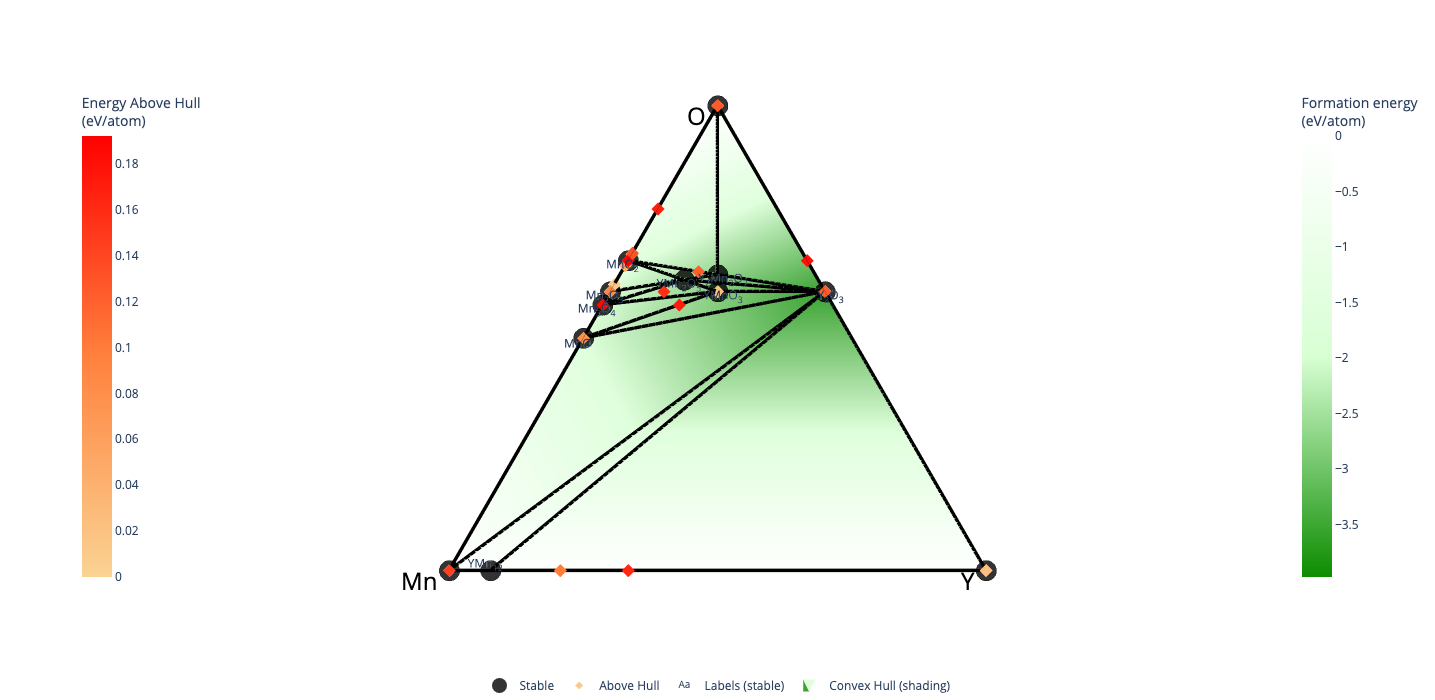

In [15]:
plotter.get_plot()

The default backend for plotting phase diagrams is *plotly*, however, you can also specify *matplotlib*:

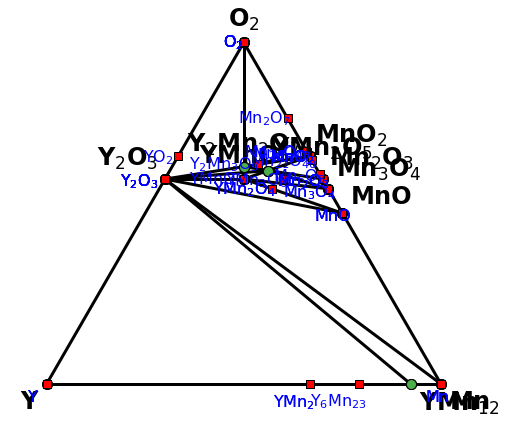

In [16]:
plotter = PDPlotter(pd, backend="matplotlib")
plotter.show()

From the phase diagram, we see that there are three ternary oxides within the system: YMnO$_3$, YMn$_2$O$_5$, and Y$_2$Mn$_2$O$_7$. 

Let's look at formation energy data in a *pandas* `DataFrame`. As before, we create a function to wrangle the data into the correct format:

In [17]:
def get_df_from_pd(pd):
    ents = pd.stable_entries
    
    formulas = [e.composition.reduced_formula for e in ents]
    form_energies = [pd.get_form_energy_per_atom(e) for e in ents]
    decomp_enthalpies = [pd.get_phase_separation_energy(e) for e in ents]
    
    data = {"formula": formulas, "form_energy (eV/atom)": form_energies, "decomp_enthalpy (eV/atom)": decomp_enthalpies}
    
    df = pandas.DataFrame(data).sort_values("form_energy (eV/atom)").reset_index(drop=True)
    
    return df

We then call this function to get the data frame:

In [18]:
get_df_from_pd(pd)

formula  form_energy (eV/atom)  decomp_enthalpy (eV/atom)
0      Y2O3              -3.970920                  -0.856833
1     YMnO3              -3.036007                  -0.029013
2   Y2Mn2O7              -2.877818                  -0.056013
3    YMn2O5              -2.639070                  -0.031220
4     Mn3O4              -2.050443                  -0.046443
5     Mn2O3              -2.013920                  -0.024500
6       MnO              -1.979201                  -0.185063
7      MnO2              -1.805830                  -0.066579
8     YMn12              -0.001407                  -0.001407
9         Y               0.000000                   0.000000
10       Mn               0.000000                   0.000000
11       O2               0.000000                   0.000000

While YMnO$_3$ has one of the lowest formation energies within the Y-Mn-O system, it's decomposition enthalpy (energy "below" hull) is not very negative compared to the other phases in the system. This suggests that it has a low relative stability compared to the neighboring phases.

This is largely due to the fact that **Y$_2$O$_3$ is a massive thermodynamic sink** -- it has both the most negative formation energy and the most negative decomposition enthalpy. We can even see this on the color-shading of the ternary phase diagram.


### 2.3 Compound phase diagrams for plotting subsets of the convex hull

The previous analysis partially explains why synthesis routes to YMnO$_3$ from the starting binary oxides (i.e. Y$_2$O$_3$ and Mn$_2$O$_3$) require such high temperatures to proceed. We can take a slice of the hull with the `CompoundPhaseDiagram` to visualize this. First, let's import the module:

In [19]:
from pymatgen.analysis.phase_diagram import CompoundPhaseDiagram

We also have to specify the terminal compositions as `Composition` objects within pymatgen:

In [20]:
from pymatgen.core.composition import Composition
terminal_comps = [Composition("Y2O3"), Composition("Mn2O3")]

Now we can initialize the compound phase diagram object and plot it:

In [21]:
cpd = CompoundPhaseDiagram(entries, terminal_comps)

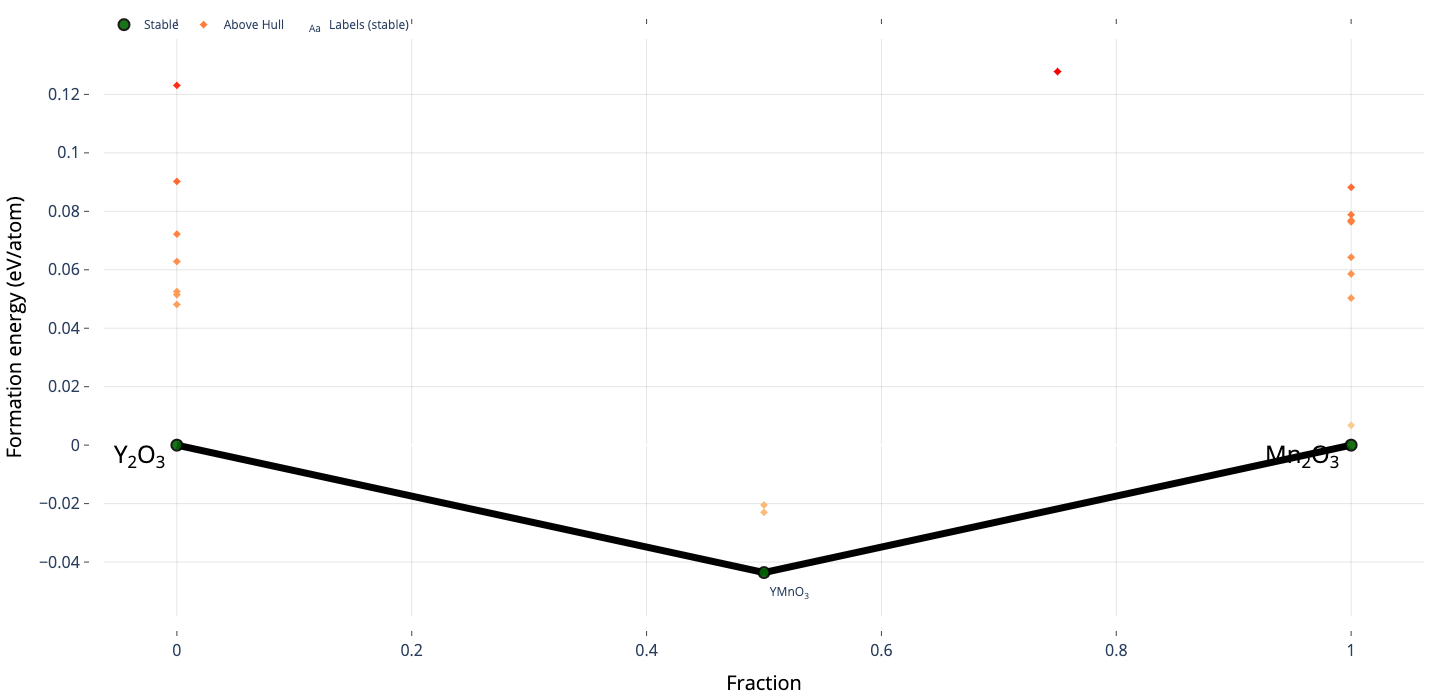

In [22]:
PDPlotter(cpd).get_plot()

From the plot, if we hover over YMnO$_3$, we see that the reaction energy between Y$_2$O$_3$-Mn$_2$O$_3$ is calculated to be $\Delta$H = -0.044 eV/atom.

An alternative way to derive this is by providing the entries to the `ComputedReaction` object, which will automatically balance the reaction for us. Let's import it:

In [23]:
from pymatgen.analysis.reaction_calculator import ComputedReaction

We next have to acquire the entries by specifying the formulas:

In [24]:
reactant_formulas = ["Y2O3", "Mn2O3"]
product_formulas = ["YMnO3"]

In [25]:
reactants = [e for e in pd.stable_entries if e.composition.reduced_formula in reactant_formulas]
products = [e for e in pd.stable_entries if e.composition.reduced_formula in product_formulas]

We can then initialize the `ComputedReaction` object:

In [26]:
rxn = ComputedReaction(reactants, products)
print(rxn)

0.5 Y2O3 + 0.5 Mn2O3 -> YMnO3


**Note:** The reaction energy associated with the ComputedReaction object is eV per mole of reaction (i.e. per mole of YMnO$_3$):

In [27]:
rxn_energy = rxn.calculated_reaction_energy
print(rxn_energy)

-0.21793684385416867


However, if we calculate the number of atoms in the reaction we can normalize this to a a **reaction energy per atom** basis:

In [28]:
num_atoms = sum([rxn.get_el_amount(elem) for elem in rxn.elements])
rxn_energy_per_atom = rxn_energy / num_atoms

print(round(rxn_energy_per_atom, 3))

-0.044


And now we see that the -0.044 eV/atom reaction energy matches with the result from the `CompoundPhaseDiagram` interface.

Note that the `CompoundPhaseDiagram` is also useful for plotting subsections of the convex hull:

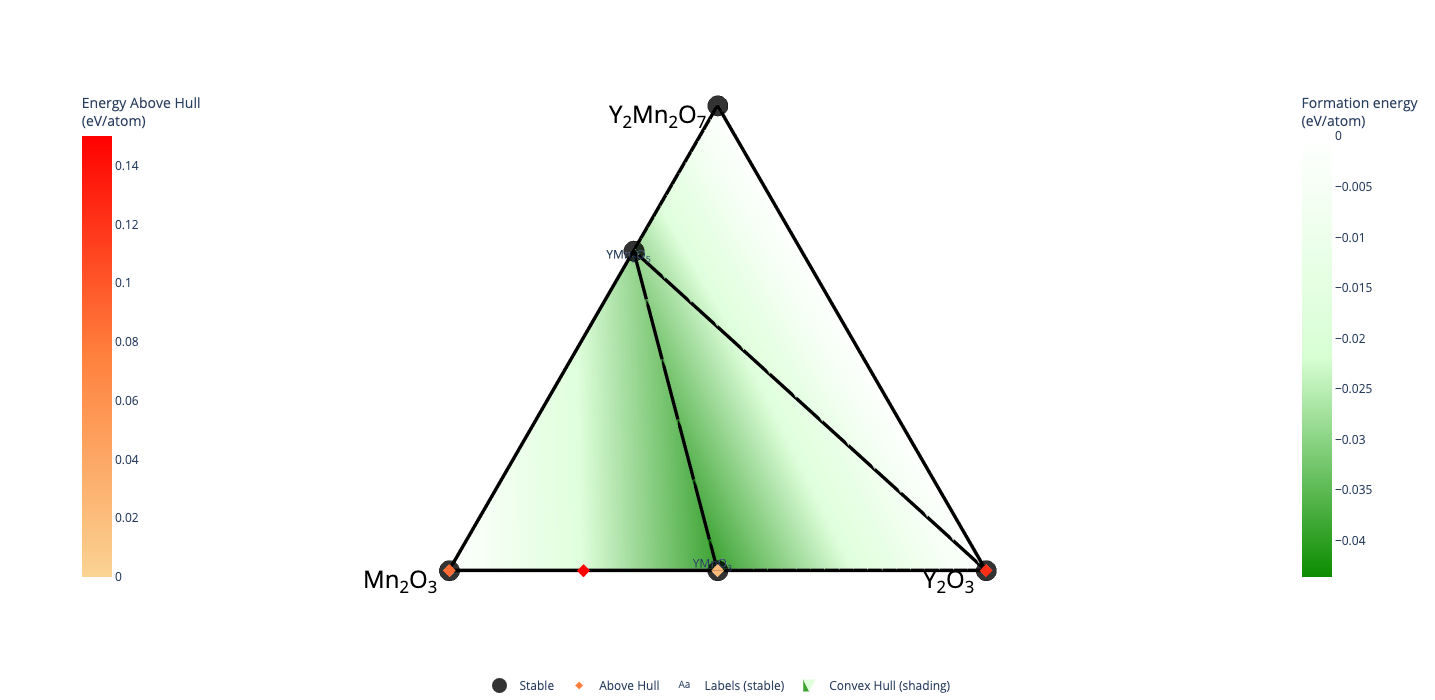

In [29]:
comps = [Composition(c) for c in ["Y2O3", "Mn2O3", "Y2Mn2O7"]]

example_cpd = CompoundPhaseDiagram(entries, comps)
PDPlotter(example_cpd).get_plot()

### 2.4 Incorporating temperature-dependence with a previously derived ML model ($G_{SISSO}$) and expt data

The Materials Project contains DFT-calculated energies for commpounds at T=0 K. Since most experimental syntheses take place well above 0 K, it is useful to have some idea of how the phase diagram (and hence reaction energies, relative stabilities, etc.) change with increasing temperature.

A recent work by Bartel et al. derived an equation to estimate the Gibbs free energy of formation of solids, $\Delta G_f(T)$, as a function of temperature using the MP formation enthalpy (T=298 K) as a reference. This has been implemented within pymatgen as the `GibbsComputedStructureEntry` class. Note that this implementation also includes the change in elemental chemical potentials as a function of temperature, as well as as the thermochemistry data for some known gases such as CO$_2$.

**Reference**: 
##### _Bartel, C. J., Millican, S. L., Deml, A. M., Rumptz, J. R., Tumas, W., Weimer, A. W., … Holder, A. M. (2018). Physical descriptor for the Gibbs energy of inorganic crystalline solids and temperature-dependent materials chemistry. Nature Communications, 9(1), 4168. https://doi.org/10.1038/s41467-018-06682-4_

We can create the phase diagram at T = 2000 K and compare this to our previous MP (T=298 K) phase diagram. First let's import the module:

In [30]:
from pymatgen.entries.computed_entries import GibbsComputedStructureEntry

Since the entries require phase diagram derived data, it is most convenient to initialize a list of them from a list of regular `ComputedStructureEntry` objects, as below:

In [31]:
gibbs_entries = GibbsComputedStructureEntry.from_entries(entries, temp=2000)

Let's print one of the entries to see what it looks like:

In [32]:
print(gibbs_entries[0])

GibbsComputedStructureEntry mp-12957 - O8
Gibbs Free Energy (Formation) = 0.0000


Now we can make and plot our phase diagram with the new Gibbs entries:

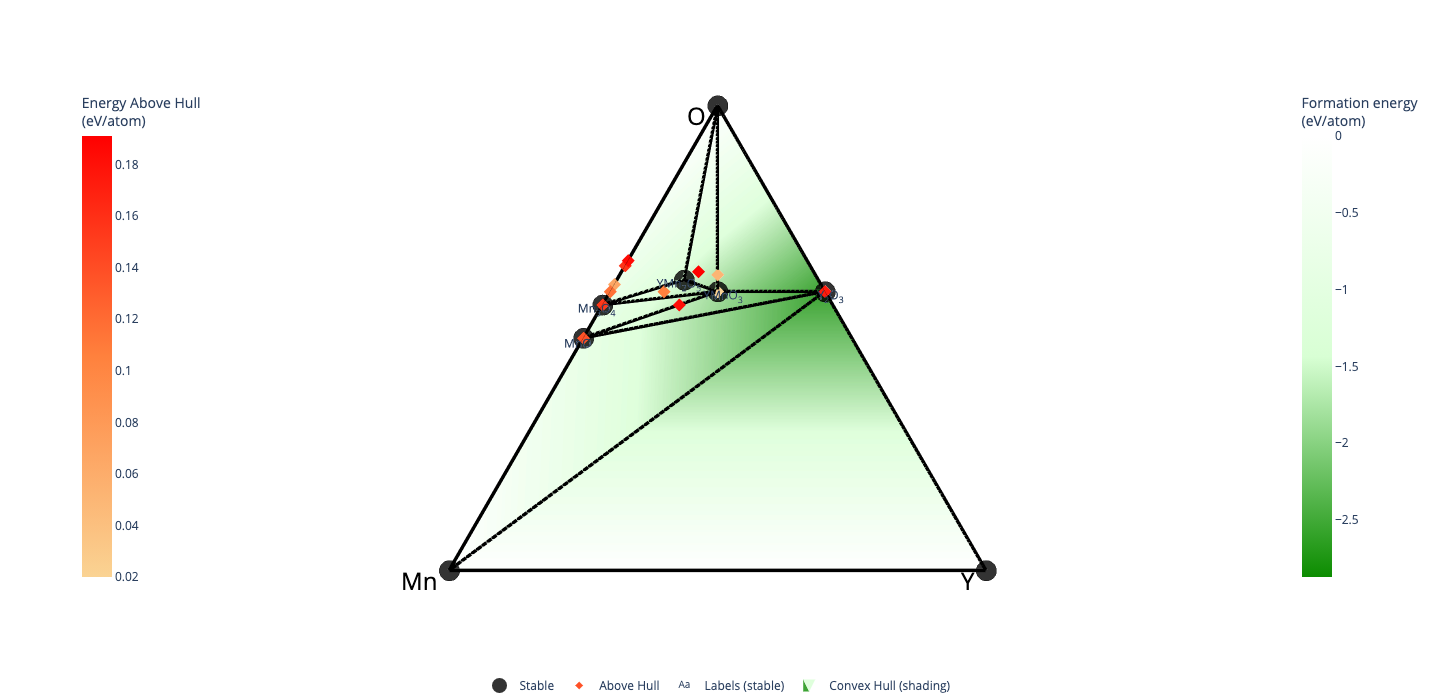

In [33]:
pd_gibbs = PhaseDiagram(gibbs_entries)
PDPlotter(pd_gibbs).get_plot()

We see that Mn$_2$O$_3$, MnO$_2$, and Y$_2$Mn$_2$O$_7$ are all predicted to become significantly destabilized at higher temperatures. While some of this behavior could arise from differences in solid-state entropies, this is most likely a result of the significant decrease in oxygen chemical potential at high temperatures, which creates more reducing conditions that favor phases containing less oxygen. 

### 2.5 Grand potential phase diagrams for open elements
In solid-state synthesis, materials are often synthesized in some type of gaseous environment. This may be an inert gas, flowing/controlled oxygen, etc. A common question in materials synthesis is: **what kind of atmosphere do I need to promote the synthesis of my target material?**

For oxides such as YMnO$_3$ this means determining how oxidizing/reducing the environment should be: i.e. determining the partial pressure (and hence chemical potential) of oxygen.

In thermodynamics, a system open to an element can be modeled with the grand potential, $\phi$. For open oxygen, this corresponds to:

$$\phi = G - \mu_On_O$$

We can switch to the grand potential by using the `GrandPotentialPhaseDiagram` within *pymatgen*. From now on, we will use `GibbsComputedStructureEntry` objects, as they are referenced to a standard state where elemental chemical potentials are 0 eV. This helps us better understand chemical potentials as a function of formation energies (rather than DFT energies).

In [34]:
from pymatgen.core.composition import Element
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram

In [35]:
temp = 1000  # temperature in Kelvin
gibbs_entries = GibbsComputedStructureEntry.from_entries(entries, temp=temp)

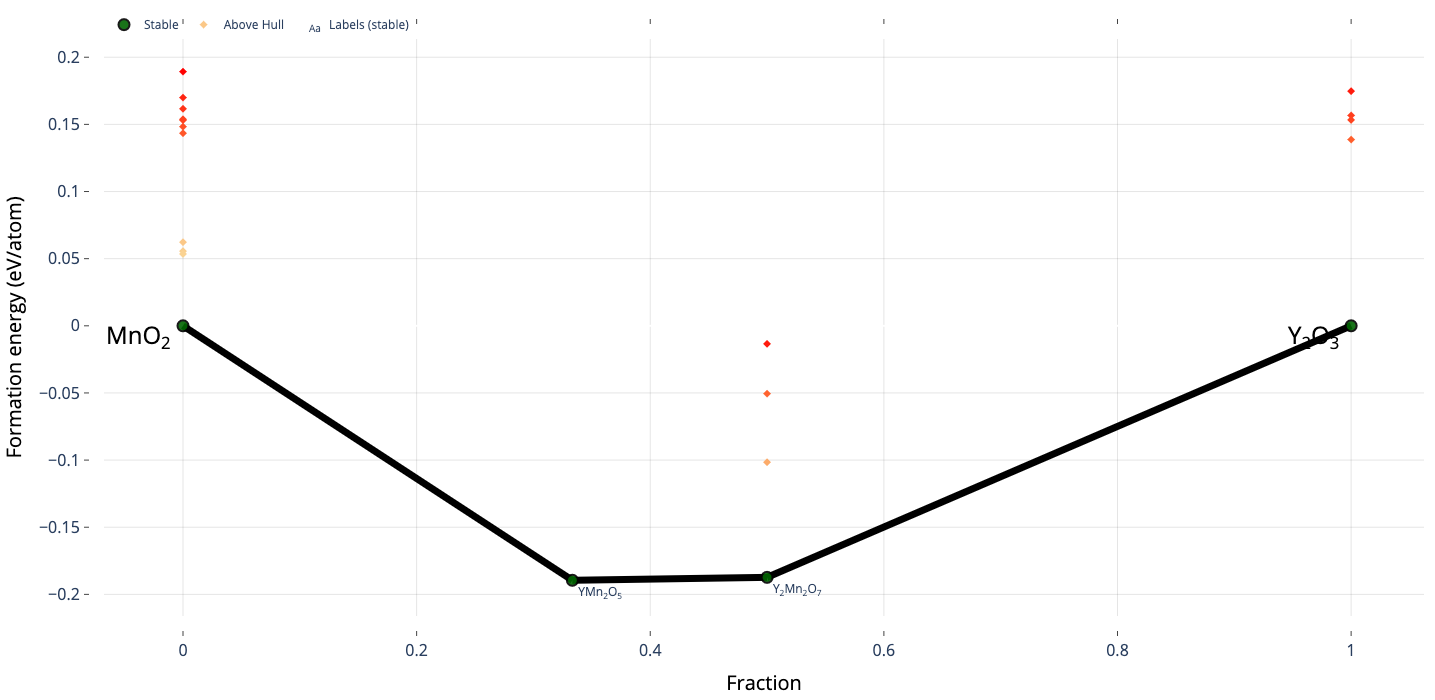

In [36]:
open_elem = Element("O")
chempot = 0
GrandPotentialPhaseDiagram(gibbs_entries, {open_elem: chempot})

From the grand potential phase diagram above, we see that only YMn$_2$O$_5$ and Y$_2$Mn$_2$O$_7$ are stable at a relative oxygen chemical potential of 0 eV at T = 1000 K. This corresponds to flowing (open) oxygen gas at the standard state of pressure of 0.1 MPa (close to 1 atm).

Note that the is for a binary system, since we have removed a degree of freedom in fixing the oxygen chemical potential to a specific value.

#### 2.5.2 EXERCISE: Determine oxygen stability window of YMnO$_3$

Determine the partial pressure of oxygen (T = 1000 K) where YMnO$_3$ becomes stable.

**Hint:** *Determine the chemical potential of oxygen and use the following formula to solve for the pressure:*

$$ \mu - \mu^0 = k_b T \ln{\frac{p}{p_0}} $$

In [37]:
from math import exp
k = 8.617e-5  # eV/K
T = 1000  # K

mu_O = -0.343 # found manually from phase diagram construction
mu_O2 = mu_O * 2  

pressure = 0.1*exp(mu_O2/(k*T))  # MPa
print(f"{round(pressure, 7)} MPa")

3.49e-05 MPa


This is quite a low O$_2$ partial pressure. However, note that this value is extremely sensitive to small differences in calculated formation energies for the compounds. 

Temperature is often an even more powerful driver for oxidizing/reducing conditions than pressure. In fact, at higher temperatures (T = 1400 K), YMnO3 is predicted to be stable even at the standard state (0.1 MPa) pressure.

#### 2.5.3 Finding "critical" chemical potentials within pymatgen

As was hinted at above, all phases on the compositional phase diagram are stable within a certain region of chemical potentials. These do not need to be found manually as above, instead there are methods to solve for them algorithmically. For YMnO$_3$, we get:

In [38]:
pd_gibbs = PhaseDiagram(gibbs_entries)
pd_gibbs.get_chempot_range_stability_phase(Composition("YMnO3"), open_elt=Element("O"))

{Element Y: (-5.684675115489508, -8.059642293382048),
 Element Mn: (-1.1179289454355414, -3.492896123328082),
 Element O: (-1.9261348812004853, -0.3428234292721252)}

Note that the upper bound value of chemical potential for oxygen matches what we found in the previous exercise (-0.343 eV).

### 2.6 Plotting predominance diagrams

The chemical potential ranges over which a phase is stable can be plotted in a new diagram, historically called a predominance diagram. Because one chemical potential is always dependent, we only need 2 dimensions to represent the chemical potential stability regions. These form polygons, which are not necessarily rectangular!

**Note:** the -0.343 eV value where YMnO$_3$ becomes stable is actually the tip of the narrow YMnO$_3$ polygon!

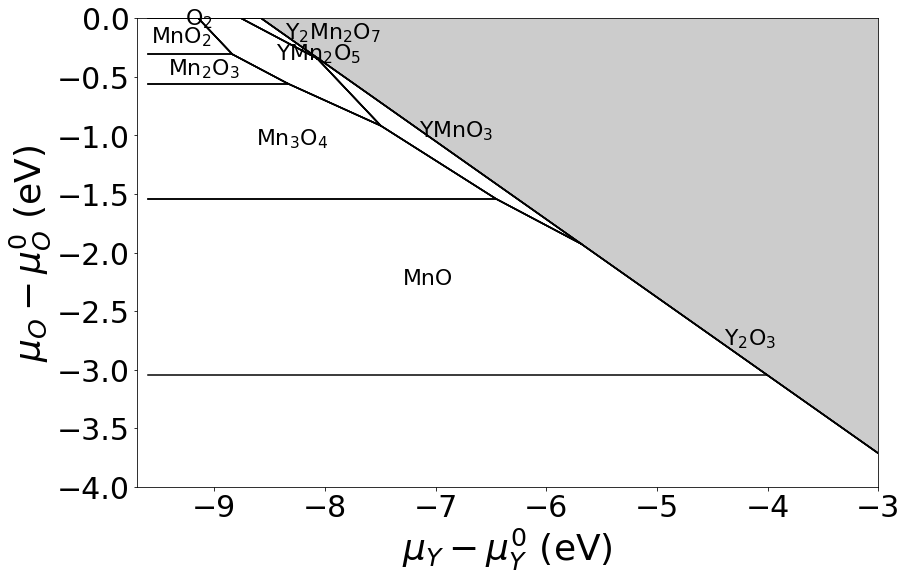

In [39]:
plotter = PDPlotter(pd_gibbs)
plot = plotter.get_chempot_range_map_plot(elements=[Element("Y"), Element("O")])
plot.xlim(-9.7, -3)
plot.ylim(-4,0)
plot.show()

### 2.7 BONUS: Plotting chemical potential diagrams (adding one more dimension!)

It is often even more convenient to visualize all three dimensions within chemical potential space. For this, we can plot a **chemical potential diagram**. For now, this code only exists in the (separate) reaction-network package, but will be added soon to pymatgen.

In [40]:
from rxn_network.thermo.chempot_diagram import ChempotDiagram

To create the diagram, we first need to define some limits on the chemical potential ranges to plot:

In [41]:
limits={Element("Y"): (-10, 0),
        Element("Mn"): (-10, 0),
        Element("O"): (-7, 0)
       }

And then we can plot it similar to plotting a conventional phase diagram in pymatgen:

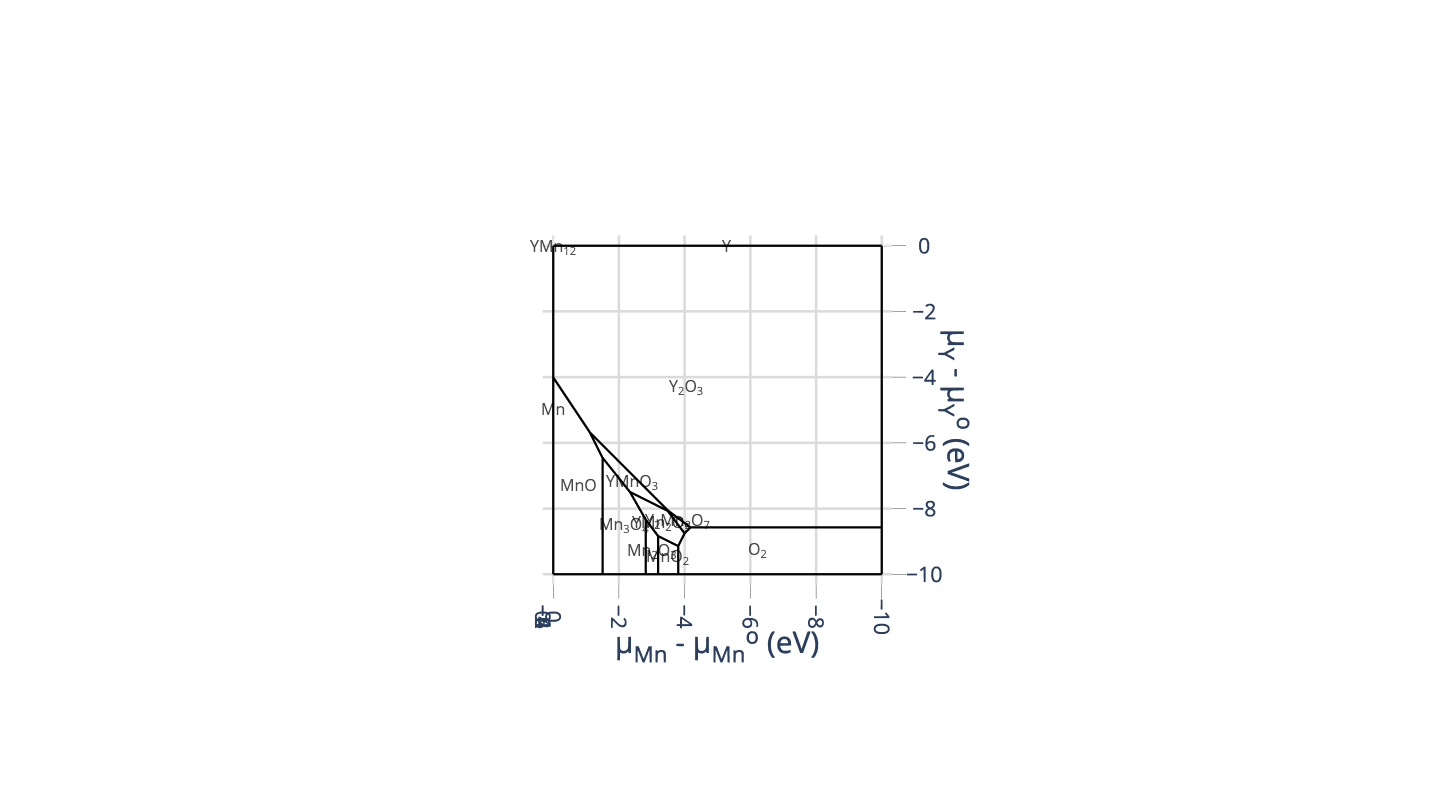

In [42]:
cd = ChempotDiagram(pd_gibbs, limits=limits)
cd.get_plot()

From the chemical potential diagram, we can easily see the relative stabilities of each phase and get a visual picture of where the critical chemical potentials are for each phase.

## 3. Predicting interface reactions between solids

### 3.1 A simple model of solid-state synthesis

In solid-state synthesis, precursor compounds are typically ground/milled into powders of small solid crystallites. These powders are intimately mixed, typically pressed into a pellet, and then heated in a furnace. Typically, solid-state synthesis involves high temperatures (i.e. 1200 ºC) and long heating times (24-72 hrs). However, many reactions can proceed significantly faster (on the order of a few minutes) and at temperatures as low as 400-500ºC. 

A simple cartoon of solid-state synthesis can be seen below:

<img src="assets/interface_rxn.png" width="750">

At the interfaces where solid crystallites touch, if the free energy of the system can be decreased by forming a new phase or set of phases, the new phase(s) will nucleate and grow.

We can predict the possible reactions between the interface of any two phases by drawing a line (see the red dashed line below) connecting the two phases on the phase diagram. A reaction is given by each point where the connecting line intersects the phase diagram points/lines. 

In the hypothetical system below, there are two predicted reactions given by the yellow star and green circle -- in this case **the reaction to form $\gamma$ (green circle) is the most thermodynamically favorable** because it involves the greatest decrease in free energy. However, the reaction given by the yellow star is still favorable and may occur at higher temperatures / later times.

<img src="assets/interface_pd.png" width="900">

### 3.2 Using pymatgen's interface reaction calculator

The phase diagram slice approach depicted above has been implemented into pymatgen within the `InterfacialReactivity` class and is available as an app on the MP website. 

Let's see if we can apply it within the Y-Mn-O chemical system to better understand the synthesis of our YMnO$_3$ target. We will start with plotting the suggested reactions between Y$_2$O$_3$ and Mn$_2$O$_3$:

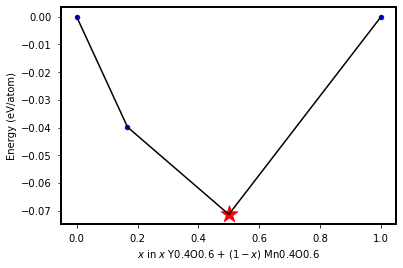

In [43]:
from pymatgen.analysis.interface_reactions import InterfacialReactivity

ir = InterfacialReactivity(Composition("Y2O3"), Composition("Mn2O3"), pd_gibbs)
ir.plot().show()

In the plot, we see a new convex hull slice, where each point represents a reaction as a function of the (normalized) ratio of mixing between the two reactants. To see which reactions the plot above corresponds to, we need to extract data about the "kinks" within the diagram:

In [44]:
pandas.set_option("max_colwidth", 80)  # make columns wider to see full reaction

def get_df_from_interface_rxns(ir):
    critical_rxns = [
        {"Atomic fraction":round(ratio, 3),
         "Reaction": rxn,
            "E$_{rxn}$ (kJ/mol)": round(rxn_energy, 1),
            "E$_{rxn}$ (eV/atom)":round(reactivity, 3)
        }
        for _, ratio, reactivity, rxn, rxn_energy in ir.get_kinks()
    ]
    
    ir_df = pandas.DataFrame(critical_rxns)
    return ir_df

In [45]:
ir_df = get_df_from_interface_rxns(ir)
ir_df

Atomic fraction  \
0            0.000   
1            0.167   
2            0.500   
3            1.000   

                                                     Reaction  \
0                                              Mn2O3 -> Mn2O3   
1  0.8333 Mn2O3 + 0.1667 Y2O3 -> 0.3333 YMn2O5 + 0.3333 Mn3O4   
2                               0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3   
3                                                Y2O3 -> Y2O3   

   E$_{rxn}$ (kJ/mol)  E$_{rxn}$ (eV/atom)  
0                 0.0                0.000  
1               -19.2               -0.040  
2               -34.4               -0.071  
3                 0.0                0.000

In the table, we see the reactions as a function of the normalized mixing ratio, along with their energy in kJ per mole of reaction, as well as eV per (reactant) atom. 

It seems that YMnO$_3$ is indeed the major predicted reaction product when Y$_2$O$_3$ and and Mn$_2$O$_3$ are combined in equal molar amounts. However, the reaction forming YMn$_2$O$_5$ and Mn$_3$O$_4$ could still occur to some degree depending on the process by which the synthesis procedure occurs (i.e. initial grain sizes, heating rate, maximum temperature reached, etc.) This is because **there is still a thermodynamic driving force for subsequent interfacial reaction between YMnO$_3$ and any remaining precursor Mn$_2$O$_3$**:

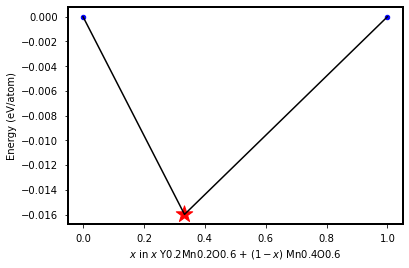

Atomic fraction  \
0            0.000   
1            0.333   
2            1.000   

                                                      Reaction  \
0                                               Mn2O3 -> Mn2O3   
1  0.6667 Mn2O3 + 0.3333 YMnO3 -> 0.3333 YMn2O5 + 0.3333 Mn3O4   
2                                               YMnO3 -> YMnO3   

   E$_{rxn}$ (kJ/mol)  E$_{rxn}$ (eV/atom)  
0                 0.0                0.000  
1                -7.7               -0.016  
2                 0.0                0.000

In [46]:
ir = InterfacialReactivity(Composition("YMnO3"), Composition("Mn2O3"), pd_gibbs)
ir.plot().show()
get_df_from_interface_rxns(ir)

It turns out that this is true again for any Mn$_3$O$_4$ produced, which may react with remaining Y$_2$O$_3$ precursor to make YMnO$_3$ and MnO. The same goes again for MnO and Mn$_2$O$_3$. 

Just in this simple ternary system, we can already see the **complex (and sometimes unpredictable) behavior associated with reaction pathways within solid-state synthesiss**. To organize this progression of reactions, we choose to create a graph network representation of the possible reaction pathway, such as the one illustrated below:

<img src="assets/small_rxn_network.png" width="900">

Before we can explore this reaction network structure further, however, we need to first discuss how to acquire all possible reactions which may occur within a chemical system.

## 4. Enumerating all reactions within a chemical system

As we saw above, the possibility of subsequent reactions makes a model for solid-state synthesis quite complex. If we wish to capture this behavior, we first need to be able to enumerate through all possible reactions within a chemical system. These reactions will then be used to construct the reaction network.

There are two methods for predicting reactions in a high-throughput manner: 

1) interface reactions iteration through all possible slices of the full phase diagram (as above)
2) brute force trial & error balancing between set of reactants and any set of products

Both of these methods are implemented in the *reaction-network* package, which builds reaction network analysis on top of pymatgen:

<img src="assets/logo.png" width="700">

### 4.1 Minimize Gibbs (interface reaction) approach

First, we need to come up with a candidate set of entries. Since we are using the reaction-network package, we are going to initialize the entries using that package's convenience methods:

In [47]:
from rxn_network.entries.entry_set import GibbsEntrySet
gibbs_entry_set = GibbsEntrySet.from_entries(entries, temperature=1000)
stable_entries = gibbs_entry_set.filter_by_stability(e_above_hull=0)

Now, we can initialize the enumerator object:

In [48]:
from rxn_network.enumerators.minimize import MinimizeGibbsEnumerator

mge = MinimizeGibbsEnumerator()

To enumerate reactions, we call `enumerate()` with a list of provided entries. This will return a list of reactions which are computed using the interface reaction method from above:

In [49]:
rxns = mge.enumerate(stable_entries)

  0%|          | 0/4 [00:00<?, ?it/s]

As before, let's look at these in a DataFrame:

In [50]:
def get_df_from_rxns(rxns):
    energies = [r.energy_per_atom for r in rxns]
    uncertainties = [r.energy_uncertainty_per_atom.s for r in rxns]
    chemsyses = [r.chemical_system for r in rxns]
    
    data = {"reaction": rxns, "energy": energies, "dE": uncertainties, "chemsys": chemsyses}
    
    return pandas.DataFrame(data).sort_values("energy").reset_index(drop=True)

In [51]:
df = get_df_from_rxns(rxns)
df

reaction    energy        dE  \
0                              2 Y + 1.5 O2 -> Y2O3 -3.429551  0.061644   
1                MnO2 + 1.333 Y -> Mn + 0.6667 Y2O3 -1.760296  0.055203   
2                  12 MnO2 + 17 Y -> YMn12 + 8 Y2O3 -1.728019  0.054636   
3                    YMn12 + 7 O2 -> YMnO3 + 11 MnO -1.704301  0.054747   
4   0.08333 YMn12 + 0.5625 O2 -> MnO + 0.04167 Y2O3 -1.700115  0.057648   
..                                              ...       ...       ...   
56           MnO + 0.5 Y2Mn2O7 -> YMnO3 + 0.5 Mn2O3 -0.058041  0.053955   
57                      0.5 Mn2O3 + 0.25 O2 -> MnO2 -0.051035  0.065617   
58                      0.5 O2 + 2 YMnO3 -> Y2Mn2O7 -0.031166  0.067726   
59                               12 Mn + Y -> YMn12 -0.003815  0.068154   
60              2 MnO2 + 2 YMnO3 -> Mn2O3 + Y2Mn2O7 -0.002288  0.052478   

   chemsys  
0      O-Y  
1   Mn-O-Y  
2   Mn-O-Y  
3   Mn-O-Y  
4   Mn-O-Y  
..     ...  
56  Mn-O-Y  
57    Mn-O  
58  Mn-O-Y  
59    Mn-Y  
60  Mn-O-Y  

[61 rows x 4 columns]

We can plot a histogram of the reaction energies to get an idea of the thermodynamics of the system. Again, we see that Y$_2$O$_3$ is quite stable (the reaction on the far left!). Most reactions, however, are in the -0.4 to 0.0 eV/atom range.

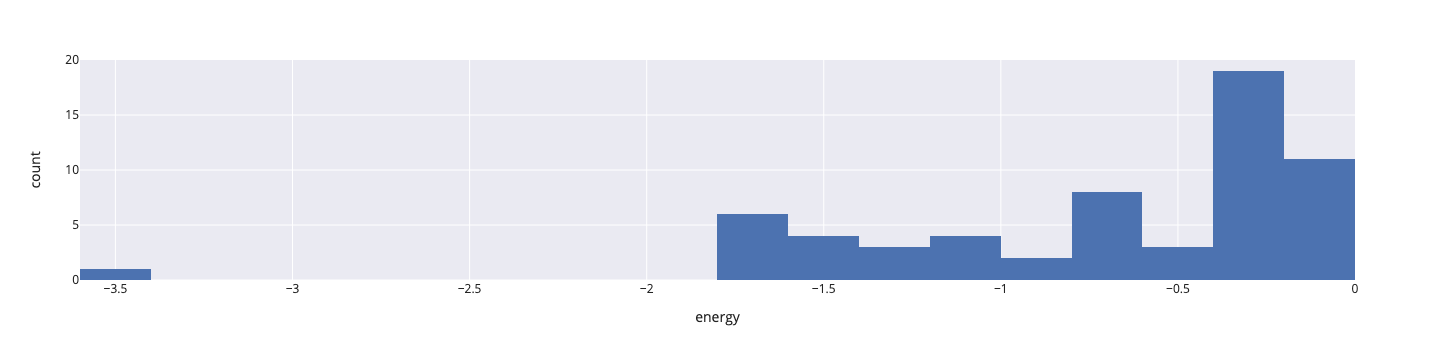

In [52]:
import plotly.express as px

px.histogram(data_frame=df, x="energy", nbins=20, template="seaborn")

### 4.2 Brute force (simple) approach

Enumerating reactions by brute force may seem like a less advanced approach, but it offers the added benefit that we can identify reactions involving:

1) metastable products
2) products which are not stable with respect to each other

This approach has been implemented with the `BasicEnumerator` class in the reaction-network package:

In [53]:
from rxn_network.enumerators.basic import BasicEnumerator
be = BasicEnumerator()

Let's try using entries up to an energy cutoff of 30 meV/atom above the hull:

In [54]:
entries_030 = gibbs_entry_set.filter_by_stability(e_above_hull=0.030)

Now we will enumerate via a brute force approach all reactions within this set of expanded entries. Note that we get both the forward and reverse reactions from this approach, producing a symmetric reaction energy distribution:

In [55]:
rxns_basic = be.enumerate(entries_030)

BasicEnumerator:   0%|          | 0/7 [00:00<?, ?it/s]

In [56]:
df = get_df_from_rxns(rxns_basic)
df

reaction    energy        dE  \
0                             Y + 0.75 O2 -> 0.5 Y2O3 -3.429551  0.061644   
1                     2 Y + 1.5 MnO2 -> Y2O3 + 1.5 Mn -1.760296  0.055203   
2            2.125 Y + 1.5 MnO2 -> Y2O3 + 0.125 YMn12 -1.728019  0.054636   
3    0.6364 O2 + 0.09091 YMn12 -> MnO + 0.09091 YMnO3 -1.704301  0.054747   
4       O2 + 0.1481 YMn12 -> 1.778 MnO + 0.07407 Y2O3 -1.700115  0.057648   
..                                                ...       ...       ...   
573     1.778 MnO + 0.07407 Y2O3 -> O2 + 0.1481 YMn12  1.700115  0.057648   
574  MnO + 0.09091 YMnO3 -> 0.6364 O2 + 0.09091 YMn12  1.704301  0.054747   
575          Y2O3 + 0.125 YMn12 -> 2.125 Y + 1.5 MnO2  1.728019  0.054636   
576                   Y2O3 + 1.5 Mn -> 2 Y + 1.5 MnO2  1.760296  0.055203   
577                           0.5 Y2O3 -> Y + 0.75 O2  3.429551  0.061644   

    chemsys  
0       O-Y  
1    Mn-O-Y  
2    Mn-O-Y  
3    Mn-O-Y  
4    Mn-O-Y  
..      ...  
573  Mn-O-Y  
574  Mn-O-Y  
575  Mn-O-Y  
576  Mn-O-Y  
577     O-Y  

[578 rows x 4 columns]

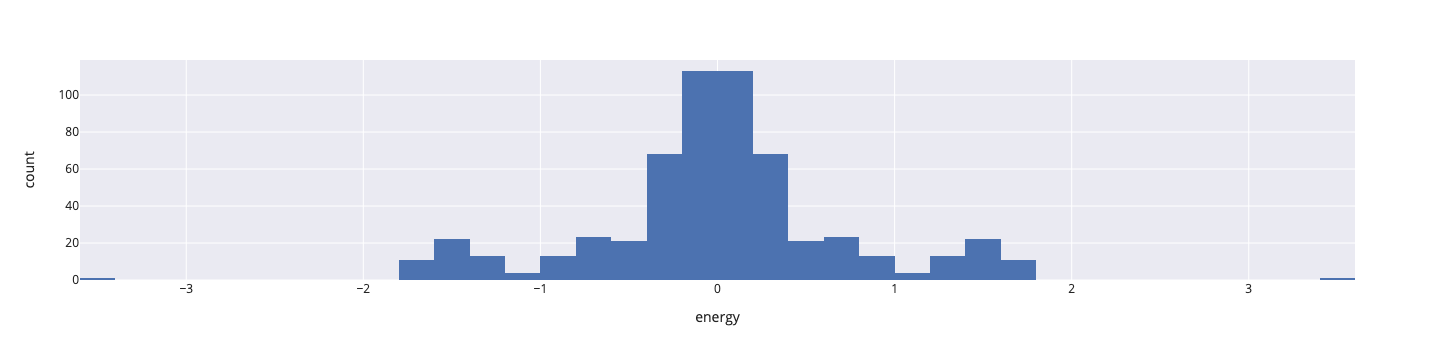

In [57]:
px.histogram(data_frame=df, x="energy", template="seaborn")

### 4.3 Enumerating reactions to a specific target or from specific precursors
The Enumerator classes also allow for specifying a desired target phase:

In [58]:
be_ymno3 = BasicEnumerator(target="YMnO3")
rxns_ymno3 = be_ymno3.enumerate(entries_030)

BasicEnumerator:   0%|          | 0/7 [00:00<?, ?it/s]

In [59]:
get_df_from_rxns(rxns_ymno3)

reaction    energy        dE  \
0   0.6364 O2 + 0.09091 YMn12 -> MnO + 0.09091 YMnO3 -1.704301  0.054747   
1    2.409 O2 + 0.2727 YMn12 -> Mn3O4 + 0.2727 YMnO3 -1.626024  0.055648   
2    1.773 O2 + 0.1818 YMn12 -> Mn2O3 + 0.1818 YMnO3 -1.621231  0.056117   
3    4.682 O2 + 0.4545 YMn12 -> Mn5O8 + 0.4545 YMnO3 -1.556305  0.056397   
4          O2 + 0.08 YMn12 -> 0.88 MnO2 + 0.08 YMnO3 -1.430899  0.057475   
..                                               ...       ...       ...   
74  1.444 MnO + 0.5185 Y2O3 -> YMnO3 + 0.03704 YMn12  0.128718  0.057905   
75                     Y2O3 + 13 Mn -> YMnO3 + YMn12  0.250953  0.054716   
76                     3 MnO + 2 Y2O3 -> Y + 3 YMnO3  0.355292  0.059457   
77   0.9231 Y2O3 + 0.07692 YMn12 -> Y + 0.9231 YMnO3  0.751377  0.059467   
78                            Y2O3 + Mn -> Y + YMnO3  0.761124  0.060093   

   chemsys  
0   Mn-O-Y  
1   Mn-O-Y  
2   Mn-O-Y  
3   Mn-O-Y  
4   Mn-O-Y  
..     ...  
74  Mn-O-Y  
75  Mn-O-Y  
76  Mn-O-Y  
77  Mn-O-Y  
78  Mn-O-Y  

[79 rows x 4 columns]

It is also possible to specify precursors:

In [60]:
be = BasicEnumerator(precursors=["Y2O3","Mn2O3"])
rxns_ymno3 = be_ymno3.enumerate(entries_030)
get_df_from_rxns(rxns_ymno3)

BasicEnumerator:   0%|          | 0/7 [00:00<?, ?it/s]

reaction    energy        dE  \
0   0.6364 O2 + 0.09091 YMn12 -> MnO + 0.09091 YMnO3 -1.704301  0.054747   
1    2.409 O2 + 0.2727 YMn12 -> Mn3O4 + 0.2727 YMnO3 -1.626024  0.055648   
2    1.773 O2 + 0.1818 YMn12 -> Mn2O3 + 0.1818 YMnO3 -1.621231  0.056117   
3    4.682 O2 + 0.4545 YMn12 -> Mn5O8 + 0.4545 YMnO3 -1.556305  0.056397   
4          O2 + 0.08 YMn12 -> 0.88 MnO2 + 0.08 YMnO3 -1.430899  0.057475   
..                                               ...       ...       ...   
74  1.444 MnO + 0.5185 Y2O3 -> YMnO3 + 0.03704 YMn12  0.128718  0.057905   
75                     Y2O3 + 13 Mn -> YMnO3 + YMn12  0.250953  0.054716   
76                     3 MnO + 2 Y2O3 -> Y + 3 YMnO3  0.355292  0.059457   
77   0.9231 Y2O3 + 0.07692 YMn12 -> Y + 0.9231 YMnO3  0.751377  0.059467   
78                            Y2O3 + Mn -> Y + YMnO3  0.761124  0.060093   

   chemsys  
0   Mn-O-Y  
1   Mn-O-Y  
2   Mn-O-Y  
3   Mn-O-Y  
4   Mn-O-Y  
..     ...  
74  Mn-O-Y  
75  Mn-O-Y  
76  Mn-O-Y  
77  Mn-O-Y  
78  Mn-O-Y  

[79 rows x 4 columns]

Or even specify both precursors *and* target:

In [61]:
be = BasicEnumerator(precursors=["Y2O3","Mn2O3"], target="YMnO3")

In [62]:
rxns_ymno3 = be.enumerate(entries_030)
get_df_from_rxns(rxns_ymno3)

BasicEnumerator:   0%|          | 0/7 [00:00<?, ?it/s]

reaction   energy        dE chemsys
0  Mn2O3 + Y2O3 -> 2 YMnO3 -0.07127  0.061237  Mn-O-Y

### 4.4 BONUS: Enumerating open reactions

Since solid-state synthesis often happens in the presence of some kind of gaseous or "open" environment, it is also possible to enumerate so-called open reactions where a particular entry is open.

In [63]:
from rxn_network.enumerators.basic import BasicOpenEnumerator

In [64]:
boe = BasicOpenEnumerator(["O2"])
open_rxns = boe.enumerate(entries_030)

BasicOpenEnumerator:   0%|          | 0/7 [00:00<?, ?it/s]

In [65]:
get_df_from_rxns(open_rxns)

reaction  \
0                                            Y + 0.75 O2 -> 0.5 Y2O3   
1         Y + 0.02703 MnO + 0.7568 O2 -> 0.4865 Y2O3 + 0.02703 YMnO3   
2     Y + 0.03846 Mn2O3 + 0.7692 O2 -> 0.03846 Y2Mn2O7 + 0.4615 Y2O3   
3        Y + 0.04569 Mn3O4 + 0.7614 O2 -> 0.4315 Y2O3 + 0.1371 YMnO3   
4                Y + O2 + 0.02564 YMn12 -> 0.359 Y2O3 + 0.3077 YMnO3   
...                                                              ...   
1523             0.359 Y2O3 + 0.3077 YMnO3 -> Y + O2 + 0.02564 YMn12   
1524     0.4315 Y2O3 + 0.1371 YMnO3 -> Y + 0.04569 Mn3O4 + 0.7614 O2   
1525  0.03846 Y2Mn2O7 + 0.4615 Y2O3 -> Y + 0.03846 Mn2O3 + 0.7692 O2   
1526      0.4865 Y2O3 + 0.02703 YMnO3 -> Y + 0.02703 MnO + 0.7568 O2   
1527                                         0.5 Y2O3 -> Y + 0.75 O2   

        energy        dE chemsys  
0    -3.429551  0.061644     O-Y  
1    -3.349437  0.059158  Mn-O-Y  
2    -3.154596  0.054649  Mn-O-Y  
3    -3.045732  0.051417  Mn-O-Y  
4    -3.007624  0.049065  Mn-O-Y  
...        ...       ...     ...  
1523  3.007624  0.049065  Mn-O-Y  
1524  3.045732  0.051417  Mn-O-Y  
1525  3.154596  0.054649  Mn-O-Y  
1526  3.349437  0.059158  Mn-O-Y  
1527  3.429551  0.061644     O-Y  

[1528 rows x 4 columns]

If these reactions involve an open entry that is also an element, then it is possible to recalculate the reaction energy in terms of grand potential:

In [66]:
from rxn_network.reactions.reaction_set import ReactionSet

In [67]:
rxn_set = ReactionSet.from_rxns(open_rxns)
open_rxns_grand = rxn_set.get_rxns(open_elem=Element("O"), chempot=0.0)

In [68]:
get_df_from_rxns(open_rxns_grand)

reaction  \
0                                            Y + 0.75 O2 -> 0.5 Y2O3   
1         Y + 0.02703 MnO + 0.7568 O2 -> 0.4865 Y2O3 + 0.02703 YMnO3   
2     Y + 0.03846 Mn2O3 + 0.7692 O2 -> 0.03846 Y2Mn2O7 + 0.4615 Y2O3   
3             Y + O2 + 0.01961 YMn12 -> 0.1176 Y2Mn2O7 + 0.3922 Y2O3   
4                     Y + O2 + 0.25 Mn -> 0.125 Y2Mn2O7 + 0.375 Y2O3   
...                                                              ...   
1523                  0.125 Y2Mn2O7 + 0.375 Y2O3 -> Y + O2 + 0.25 Mn   
1524          0.1176 Y2Mn2O7 + 0.3922 Y2O3 -> Y + O2 + 0.01961 YMn12   
1525  0.03846 Y2Mn2O7 + 0.4615 Y2O3 -> Y + 0.03846 Mn2O3 + 0.7692 O2   
1526      0.4865 Y2O3 + 0.02703 YMnO3 -> Y + 0.02703 MnO + 0.7568 O2   
1527                                         0.5 Y2O3 -> Y + 0.75 O2   

        energy        dE chemsys  
0    -8.573877  0.154110       Y  
1    -8.373593  0.147896    Mn-Y  
2    -7.999155  0.138574    Mn-Y  
3    -7.748977  0.129626    Mn-Y  
4    -7.694811  0.129422    Mn-Y  
...        ...       ...     ...  
1523  7.694811  0.129422    Mn-Y  
1524  7.748977  0.129626    Mn-Y  
1525  7.999155  0.138574    Mn-Y  
1526  8.373593  0.147896    Mn-Y  
1527  8.573877  0.154110       Y  

[1528 rows x 4 columns]

Similarly, it is also possible to enumerate reactions straight from the grand potential phase diagram:

In [69]:
from rxn_network.enumerators.minimize import MinimizeGrandPotentialEnumerator

mgpe = MinimizeGrandPotentialEnumerator(open_elem=Element("O"), mu=0.0)
open_rxns2 = mgpe.enumerate(entries_030)

  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
get_df_from_rxns(open_rxns2)

reaction    energy        dE  \
0                               2 Y + 1.5 O2 -> Y2O3 -8.573877  0.154110   
1                     2 Mn + 2 Y + 3.5 O2 -> Y2Mn2O7 -6.376210  0.166771   
2         0.1667 YMn12 + 1.833 Y + 3.5 O2 -> Y2Mn2O7 -6.374144  0.166797   
3                    2 MnO + 2 Y + 2.5 O2 -> Y2Mn2O7 -4.854178  0.161051   
4           0.6667 Mn3O4 + 2 Y + 2.167 O2 -> Y2Mn2O7 -4.679241  0.160835   
5                0.4 Mn5O8 + 2 Y + 1.9 O2 -> Y2Mn2O7 -4.568917  0.161284   
6                      Mn2O3 + 2 Y + 2 O2 -> Y2Mn2O7 -4.550820  0.161051   
7                   2 MnO2 + 2 Y + 1.5 O2 -> Y2Mn2O7 -4.474267  0.162980   
8             2 YMn12 + 25.5 O2 -> Y2Mn2O7 + 22 MnO2 -4.195813  0.169340   
9                                    Mn + O2 -> MnO2 -3.803885  0.187083   
10  0.1667 YMn12 + 0.9167 Y2O3 + 2.125 O2 -> Y2Mn2O7 -2.444450  0.160450   
11                     2 Mn + Y2O3 + 2 O2 -> Y2Mn2O7 -2.089271  0.161051   
12                              MnO + 0.5 O2 -> MnO2 -0.759822  0.187083   
13                      2 MnO + Y2O3 + O2 -> Y2Mn2O7 -0.567240  0.161051   
14                  0.3333 Mn3O4 + 0.3333 O2 -> MnO2 -0.409947  0.192931   
15        0.6667 Mn3O4 + Y2O3 + 0.6667 O2 -> Y2Mn2O7 -0.392302  0.162767   
16              0.4 Mn5O8 + Y2O3 + 0.4 O2 -> Y2Mn2O7 -0.281979  0.164735   
17                  Mn2O3 + Y2O3 + 0.5 O2 -> Y2Mn2O7 -0.263881  0.163936   
18                        0.2 Mn5O8 + 0.2 O2 -> MnO2 -0.189300  0.199499   
19                       0.5 Mn2O3 + 0.25 O2 -> MnO2 -0.153105  0.196850   
20                       2 YMnO3 + 0.5 O2 -> Y2Mn2O7 -0.085706  0.186246   

   chemsys  
0        Y  
1     Mn-Y  
2     Mn-Y  
3     Mn-Y  
4     Mn-Y  
5     Mn-Y  
6     Mn-Y  
7     Mn-Y  
8     Mn-Y  
9       Mn  
10    Mn-Y  
11    Mn-Y  
12      Mn  
13    Mn-Y  
14      Mn  
15    Mn-Y  
16    Mn-Y  
17    Mn-Y  
18      Mn  
19      Mn  
20    Mn-Y

## 5. Constructing a reaction network from enumerated reactions

Now that we have a way to enumerate all reactions within a chemical system, we'd like to be able to put them in a convenient data structure such that we can learn something. One particular data structure that is helpful for predicting reaction pathways is a **weighted directed graph**. 

The weighted directed graph, or reaction network, connects all phases within the chemical system via the possible reactions between them. This corresponds to a structure like the following:
- **Nodes**: Phase combinations
- **Edges**: Reactions
- **Edge weights/costs**: Reaction free energies (after monotonic transformation)

The function that monotonically transforms reaction free energies to (positive) costs/weights is dubbed a cost function.

For more information about this approach, please see the following publication:

**Reference:** *McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x*

Let's start by reacquiring entries for the Y-Mn-O system and filtering for stable entries.

In [71]:
with MPRester() as mpr:
    mp_entries = mpr.get_entries_in_chemsys("Y-Mn-O")

In [72]:
gibbs_entries = GibbsEntrySet.from_entries(mp_entries, temperature=900).filter_by_stability(0)

Now we specify the enumerator(s) and cost function to use in the network construction. At the moment, only the softplus function is implemented.

In [73]:
from rxn_network.network.network import ReactionNetwork
from rxn_network.costs.softplus import Softplus

be = BasicEnumerator()
cf = Softplus(temp=1000)

We need to import the `logging` package to get information about the network creation process:

In [74]:
import logging

We then initialize our reaction network object:

In [75]:
rn = ReactionNetwork(gibbs_entries, [be], cf)

The network can be built by calling `build()`. This runs through each enumerator provided, and constructs the reaction network structure within the _graph-tool_ package. The graph object is stored under the `graph` attribute.

In [76]:
rn.build()

BasicEnumerator:   0%|          | 0/7 [00:00<?, ?it/s]

In [77]:
print(rn.graph)

<Graph object, directed, with 86 vertices and 267 edges, 2 internal vertex properties, 3 internal edge properties, at 0x7fc9ea1a2f10>


To perform pathfinding, we first need to set the precursors and target defining the particular synthesis procedure we are interested in. For now, let's look at the synthesis of YMnO3 from the starting binary oxides, Y2O3 and Mn2O3. We first acquire the entries from the set of entries by providing the formula:

In [78]:
y2o3_entry = gibbs_entries.get_min_entry_by_formula("Y2O3")
mn2o3_entry = gibbs_entries.get_min_entry_by_formula("Mn2O3")
ymno3_entry = gibbs_entries.get_min_entry_by_formula("YMnO3")

And then we set the precursors and target nodes:

In [79]:
rn.set_precursors([y2o3_entry, mn2o3_entry])
rn.set_target(ymno3_entry)

We can also draw a cartoon illustration of what this reaction network looks like:

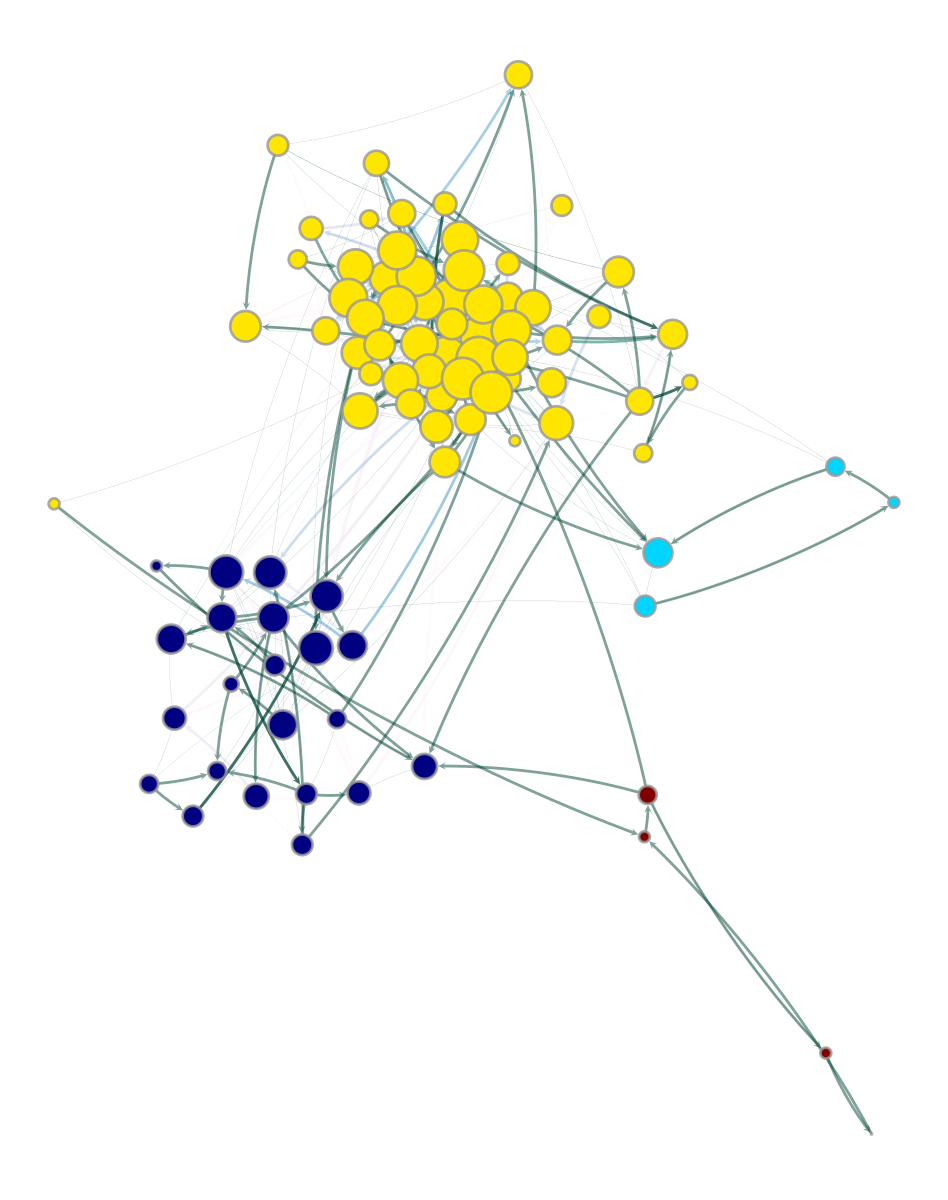

In [80]:
from rxn_network.network.visualize import plot_network
plot_network(rn.graph);

We can perform simple pathfinding between the precursors node and target node. This finds the k-shortest paths between our precursors and target, which yields a sequence of reaction steps. **Note: these are not necessarily mass balanced!**

In [81]:
paths = rn.find_pathways(["YMnO3"], k=10)

PATHS to YMnO3 

--------------------------------------- 

Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.227 

1.026 Y2O3 + 1.308 Mn2O3 -> Y2Mn2O7 + 0.05128 YMn12 (dG = 0.142 eV/atom) 
Mn2O3 + 0.07143 YMn12 -> 2.786 MnO + 0.07143 YMnO3 (dG = -0.349 eV/atom) 
Total Cost: 0.45 

1.333 Y2O3 + Mn2O3 -> Y2Mn2O7 + 0.6667 Y (dG = 0.401 eV/atom) 
Mn2O3 + Y -> Mn + YMnO3 (dG = -0.877 eV/atom) 
Total Cost: 0.45 

1.333 Y2O3 + Mn2O3 -> Y2Mn2O7 + 0.6667 Y (dG = 0.401 eV/atom) 
12 Mn2O3 + 13 Y -> YMn12 + 12 YMnO3 (dG = -0.866 eV/atom) 
Total Cost: 0.451 

1.026 Y2O3 + 1.308 Mn2O3 -> Y2Mn2O7 + 0.05128 YMn12 (dG = 0.142 eV/atom) 
0.07692 Mn2O3 + 0.07692 YMn12 -> Mn + 0.07692 YMnO3 (dG = -0.287 eV/atom) 
Total Cost: 0.46 

0.01282 Y2O3 + 0.6538 Mn2O3 -> MnO2 + 0.02564 YMn12 (dG = 0.365 eV/atom) 
MnO2 + 0.07143 YMn12 -> 1.786 MnO + 0.07143 YMnO3 (dG = -0.649 eV/atom) 
Total Cost: 0.465 

1.5 Y2O3 + 2 Mn2O3 -> Mn + 1.5 Y2Mn2O7 (dG = 0.121 eV/atom) 
Mn + Y2Mn2O7 -> MnO + 2 YMnO3 (dG = -0.2

## 6. BONUS: Finding and balancing reaction pathways from a real experiment

In 2019, Todd et al. reported the synthesis of YMnO3 through an "assisted metathesis" approach corresponding to the following reaction equation:

$$ Mn_2O_3 + 2 YCl_3 + 3 Li_2CO_3 \rightarrow 2 YMnO_3 + 6 LiCl + 3 CO_2 $$

They also observed the following progression of phases, as determined via in situ X-ray diffraction on a synchrotron beamline:

<img src="assets/ymno3.png" width="500">

**Reference:** *Todd, P. K., Smith, A. M., &amp; Neilson, J. R. (2019). Yttrium manganese oxide phase stability and selectivity using lithium carbonate assisted metathesis reactions. Inorganic Chemistry, 58(22), 15166–15174. https://doi.org/10.1021/acs.inorgchem.9b02075*

To model this synthesis, we first acquire the entries for the entire 6-element chemical system from MP:

In [82]:
with MPRester() as mpr:
    entries = mpr.get_entries_in_chemsys("Y-Mn-O-Li-Cl-C")

And we filter this entries by a stability filter of 20 meV/atom at T = 650 ºC:

In [83]:
temp = 650 + 273
gibbs_entries = GibbsEntrySet.from_entries(entries, temperature=temp).filter_by_stability(0.020)

We then designate the enumerator, cost function, and build the network. This may take a minute!

In [84]:
be = BasicEnumerator()
cf = Softplus(temp=temp)

In [85]:
rn = ReactionNetwork(gibbs_entries, [be], cf)

In [86]:
rn.build()

BasicEnumerator:   0%|          | 0/63 [00:00<?, ?it/s]

As before, we then set the precursors:

In [87]:
rn.set_precursors([gibbs_entries.get_min_entry_by_formula("Li2CO3"), 
                   gibbs_entries.get_min_entry_by_formula("Mn2O3"), 
                   gibbs_entries.get_min_entry_by_formula("YCl3")])

And then we perform pathfinding to all three targets simultaneously:

In [88]:
paths = rn.find_pathways(["YMnO3","LiCl","CO2"], k=10)

PATHS to YMnO3 

--------------------------------------- 

YCl3 + 4.5 Mn2O3 -> Mn8Cl3O10 + 0.5 Y2Mn2O7 (dG = -0.015 eV/atom) 
Y2Mn2O7 + Mn2O3 -> 2 MnO2 + 2 YMnO3 (dG = 0.005 eV/atom) 
Total Cost: 0.516 

YCl3 + 4.5 Mn2O3 -> Mn8Cl3O10 + 0.5 Y2Mn2O7 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.037 eV/atom) 
Total Cost: 0.523 

Li2CO3 + Mn2O3 -> Li2MnO3 + MnCO3 (dG = 0.009 eV/atom) 
YCl3 + MnCO3 -> YMnO3 + CCl3 (dG = 0.393 eV/atom) 
Total Cost: 0.625 

2 Li2CO3 + 0.5 Mn2O3 -> LiMn(CO3)2 + 1.5 Li2O (dG = 0.089 eV/atom) 
0.3333 YCl3 + 0.5 Li2O -> LiCl + 0.1667 Y2O3 (dG = -0.3 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.722 

2 Li2CO3 + 0.5 Mn2O3 -> LiMn(CO3)2 + 1.5 Li2O (dG = 0.089 eV/atom) 
0.3333 YCl3 + 0.6667 Li2O -> LiCl + 0.3333 LiYO2 (dG = -0.254 eV/atom) 
LiYO2 + Mn2O3 -> YMnO3 + LiMnO2 (dG = -0.082 eV/atom) 
Total Cost: 0.728 

2 Li2CO3 + 0.5 Mn2O3 -> LiMn(CO3)2 + 1.5 Li2O (dG = 0.089 eV/atom) 
0.3333 YCl3 + 0.6667 Li2O -> LiCl + 0.3333 LiYO2 (

Finally, we must enforce mass balance to filter out unfeasbile pathways. To do this, we import and use the `PathwaySolver` class:

In [89]:
from rxn_network.pathways.solver import PathwaySolver
from rxn_network.reactions.computed import ComputedReaction

ps = PathwaySolver(rn.entries, paths, Softplus(1000))

The `PathwaySolver` takes a net reaction by which to enforce mass balance, i.e. total consumption of all produced intermediates. This corresponds to the previous reaction formula we showed. We can create a `ComputedReaction` object by finding the relevant entries and providing them to the reaction constructor:

In [90]:
product_entries = []

for i in ["YMnO3", "LiCl", "CO2"]:
    product_entries.append(gibbs_entries.get_min_entry_by_formula(i))

In [91]:
net_rxn = ComputedReaction.balance(rn.precursors,product_entries)
print(net_rxn)

1.5 Li2CO3 + YCl3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2


Finally, we solve for the balanced paths and print them. This may take a minute!

In [92]:
balanced_paths = ps.solve(net_rxn)

BasicEnumerator:   0%|          | 0/63 [00:00<?, ?it/s]

BasicEnumerator:   0%|          | 0/63 [00:00<?, ?it/s]

BasicEnumerator:   0%|          | 0/63 [00:00<?, ?it/s]

PathwaySolver:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: iteration over a 0-d array

The final balanced pathways can be printed, as below:

In [ ]:
for p in balanced_paths:
    print(p, "\n")

As we see, the balanced pathways reported capture many of the experimentally observed intermediates and reaction steps!

For more information or questions regarding this lesson, please contact **mcdermott [at] lbl.gov** Thank you!